In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn scikit-learn tensorflow

# Facial Emotion Recognition
## Import Necessary Libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import random

## Global Variables

In [3]:
input_base_url = './'
emotions_csv_url = os.path.join(input_base_url, 'emotions.csv')
images_url = os.path.join(input_base_url, 'images')

## Read the csv file

In [4]:
df = pd.read_csv(emotions_csv_url)
df

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


## Exploratory Data Analysis

In [5]:
first_image_directory = os.path.join(images_url, '0')
first_image_directory_files = os.listdir(first_image_directory)
emotions = [os.path.splitext(file)[0] for file in first_image_directory_files]
emotions

['Happy',
 'Neutral',
 'Sad',
 'Surprised',
 'Disgust',
 'Anger',
 'Fear',
 'Contempt']

/var/folders/pg/s29lb0dd5kj_qrc9t7vh7lr00000gp/T/ipykernel_4029/898661486.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', palette='Set2')


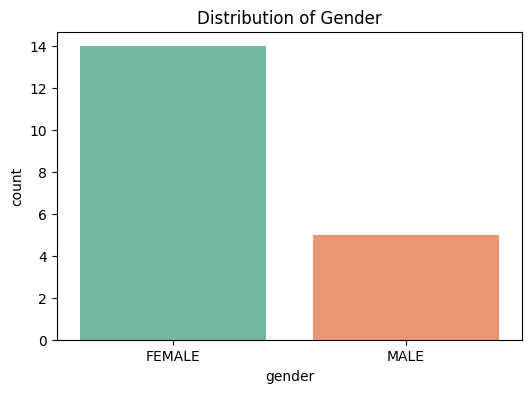

In [6]:
# Check the distribution of gender
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', palette='Set2')
plt.title('Distribution of Gender')
plt.show()

/var/folders/pg/s29lb0dd5kj_qrc9t7vh7lr00000gp/T/ipykernel_4029/939354275.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age_group', palette='Set3')


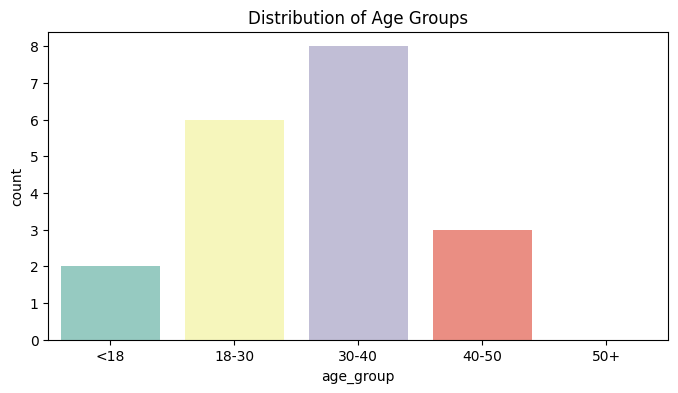

In [7]:
# Define age bins and labels
bins = [0, 18, 30, 40, 50, 100]
labels = ['<18', '18-30', '30-40', '40-50', '50+']

# Create a new column for age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# Plot the distribution of age groups
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='age_group', palette='Set3')
plt.title('Distribution of Age Groups')
plt.show()

/var/folders/pg/s29lb0dd5kj_qrc9t7vh7lr00000gp/T/ipykernel_4029/3137634474.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='country', palette='Set1', order=df['country'].value_counts().index)


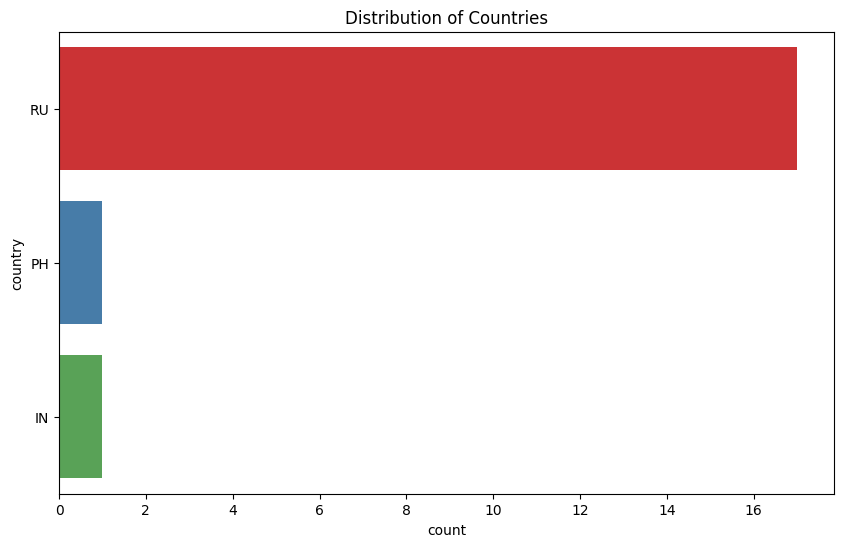

In [8]:
# Check the distribution of countries
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='country', palette='Set1', order=df['country'].value_counts().index)
plt.title('Distribution of Countries')
plt.show()

/var/folders/pg/s29lb0dd5kj_qrc9t7vh7lr00000gp/T/ipykernel_4029/3985320615.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emotion_df, x='Emotion', y='Count', palette='Set2')


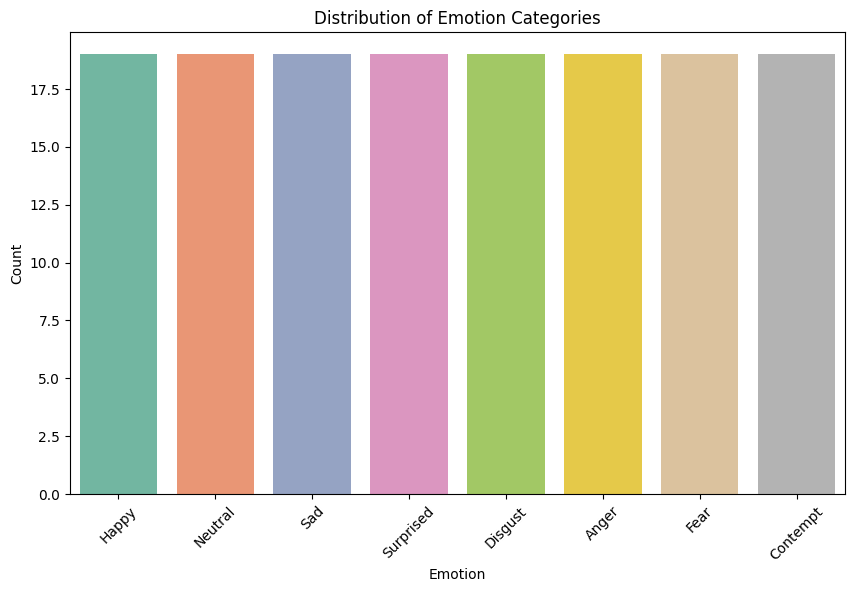

In [9]:
# Initialize a dictionary to count images per emotion
emotion_counts = {emotion: 0 for emotion in emotions}

# Loop through each numbered folder
for folder_id in range(len(df)):
    folder_path = os.path.join(images_url, str(folder_id))
    
    # Loop through each emotion file in the folder
    for emotion in emotions:
        img_path = os.path.join(folder_path, f'{emotion}.jpg')
        if os.path.exists(img_path):
            emotion_counts[emotion] += 1

# Convert the counts to a DataFrame for visualization
emotion_df = pd.DataFrame(list(emotion_counts.items()), columns=['Emotion', 'Count'])

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.barplot(data=emotion_df, x='Emotion', y='Count', palette='Set2')
plt.title('Distribution of Emotion Categories')
plt.xticks(rotation=45)
plt.show()

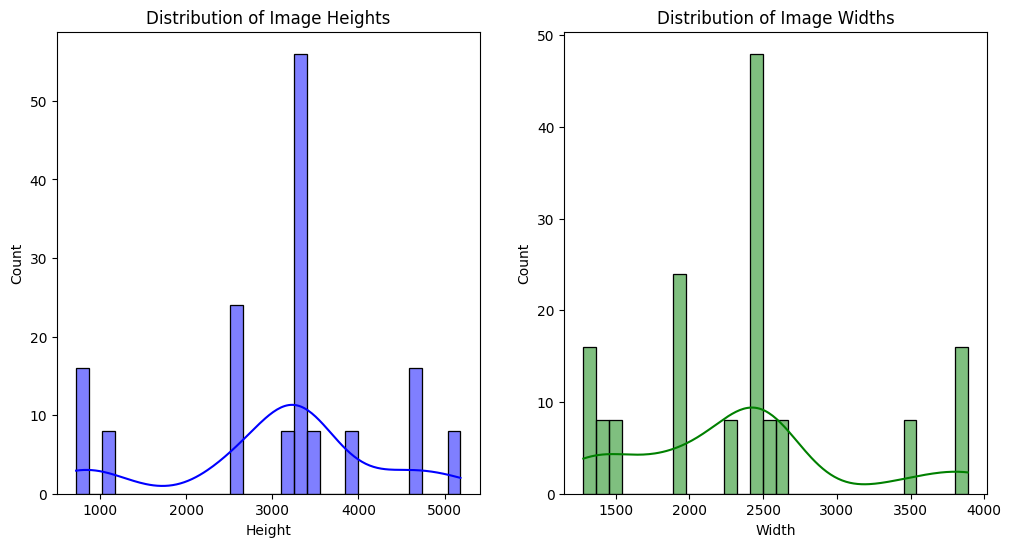

In [10]:
# Initialize lists to store image dimensions
image_heights = []
image_widths = []

# Loop through each numbered folder
for folder_id in range(len(df)):
    folder_path = os.path.join(images_url, str(folder_id))
    
    # Loop through each emotion file in the folder
    for emotion in emotions:
        img_path = os.path.join(folder_path, f'{emotion}.jpg')
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            height, width, _ = img.shape
            image_heights.append(height)
            image_widths.append(width)

# Convert to DataFrame for analysis
image_dims_df = pd.DataFrame({'Height': image_heights, 'Width': image_widths})

# Plot distribution of image heights and widths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(image_dims_df['Height'], bins=30, kde=True, color='blue')
plt.title('Distribution of Image Heights')

plt.subplot(1, 2, 2)
sns.histplot(image_dims_df['Width'], bins=30, kde=True, color='green')
plt.title('Distribution of Image Widths')

plt.show()

## Preprocessing



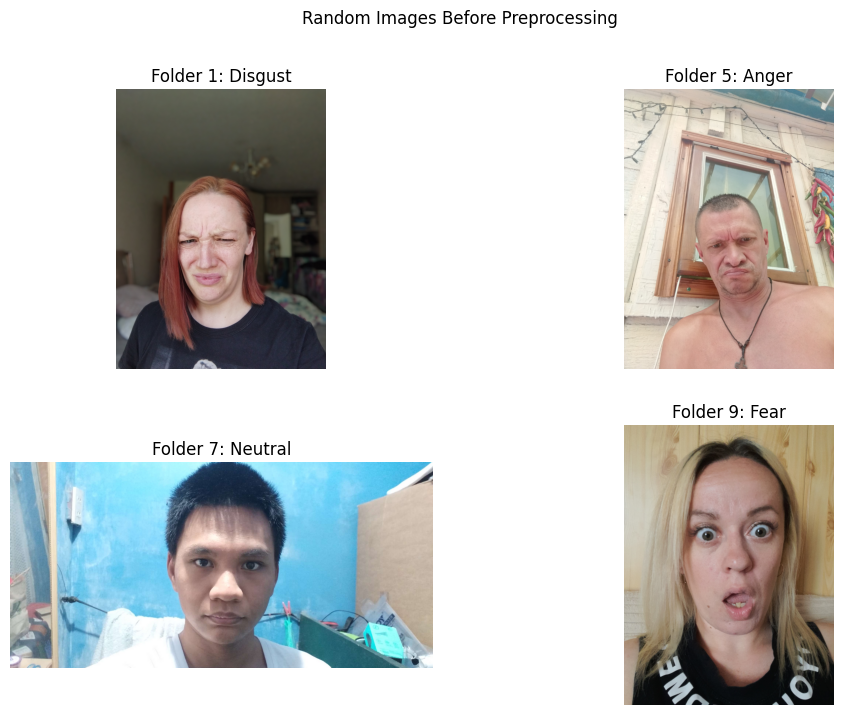

In [11]:
# Function to display random images from different folders
def show_random_images(folder_ids, num_images=4):
    plt.figure(figsize=(12, 8))
    
    for i, folder_id in enumerate(folder_ids):
        folder_path = os.path.join(images_url, str(folder_id))
        
        # Select random emotions to display
        emotion = random.choice(emotions)
        img_path = os.path.join(folder_path, f'{emotion}.jpg')
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            
            plt.subplot(2, 2, i+1)
            plt.imshow(img)
            plt.title(f'Folder {folder_id}: {emotion}')
            plt.axis('off')
    
    plt.suptitle('Random Images Before Preprocessing')
    plt.show()

# Example: Display 4 random images from folders 0, 1, 2, and 3
show_random_images(folder_ids=[1, 5, 7, 9])

### Resizing Images

In [12]:
# Set the desired image size
IMG_SIZE = 48  # or 64 depending on your choice

# Function to resize and save images
def resize_image(images_url, size):
    img = cv2.imread(images_url)
    resized_img = cv2.resize(img, (size, size))
    return resized_img

# Process all images
resized_images = []
labels = []

for folder_id in range(len(df)):
    folder_path = os.path.join(images_url, str(folder_id))
    
    for emotion in emotions:
        img_path = os.path.join(folder_path, f'{emotion}.jpg')
        if os.path.exists(img_path):
            resized_img = resize_image(img_path, IMG_SIZE)
            resized_images.append(resized_img)
            labels.append(emotion)

# Convert lists to numpy arrays
import numpy as np

X = np.array(resized_images)
y = np.array(labels)

### Normalize Pixel Values

In [13]:
# Normalize the images
X = X.astype('float32') / 255.0

### Encode Labels

In [14]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y_encoded, num_classes=len(emotions))

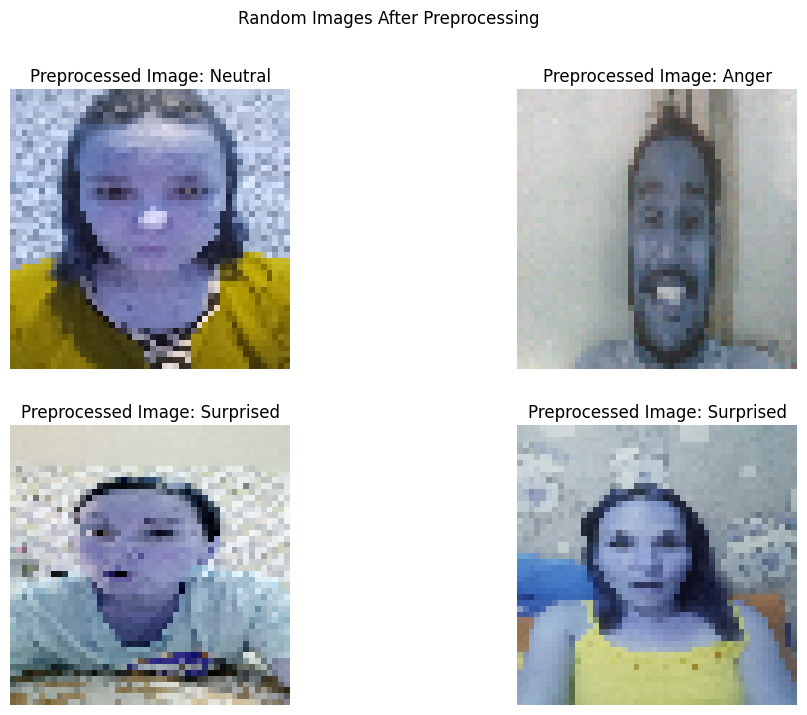

In [15]:
# Function to display random preprocessed images
def show_preprocessed_images(X, y, num_images=4):
    plt.figure(figsize=(12, 8))
    
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)  # Select a random index
        img = X[idx]
        label = y[idx]
        
        # Reverse one-hot encoding for the label
        label_decoded = label_encoder.inverse_transform([np.argmax(label)])[0]
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f'Preprocessed Image: {label_decoded}')
        plt.axis('off')
    
    plt.suptitle('Random Images After Preprocessing')
    plt.show()

# Example: Display 4 random preprocessed images
show_preprocessed_images(X, y_one_hot)